In [53]:
import os 
import glob 
import cv2 
import numpy as np 
import datetime 
import matplotlib.pyplot as plt 
import random 
import time 
import yolov5 

In [54]:
%matplotlib inline

In [55]:
# constants from kitti
baseline = 0.54  # [m]
focal_length = 721 # pixel

stereo_dir = "/data/kitti/stereo/training"
imgs_left = glob.glob(os.path.join(stereo_dir, "image_2") + "/*.png")
imgs_right = glob.glob(os.path.join(stereo_dir, "image_3") + "/*.png")

In [56]:
def compute_disparity_map(img_left, img_right, matcher='bm', rgb=False, verbose=True):
    sad_window = 6
    num_disparities = sad_window * 16
    block_size = 11

    if matcher == 'bm':
        stereo_matcher = cv2.StereoBM_create(
            numDisparities=num_disparities,
            blockSize=block_size,
        )
    elif matcher == 'sgbm':
        stereo_matcher = cv2.StereoSGBM_create(
            numDisparities=num_disparities,
            minDisparity=0,
            blockSize=block_size,
            P1=8*1*block_size**2,
            P2=32*1*block_size**2,
            mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY,
        )
    else:
        raise NotImplementedError("This matcher is not implemented.")

    if rgb:
        img_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
        img_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)

    start = time.perf_counter()
    disp_left = stereo_matcher.compute(img_left, img_right).astype(np.float32) / 16
    end = time.perf_counter()

    if verbose:
        print(f"Matcher: {matcher.upper()} | Disparity map computation time: {end-start:0.4f} seconds")

    return disp_left

In [57]:
idx = random.randint(0, len(imgs_left) - 1)
print(f"Index: {idx}")
left_img = cv2.imread(imgs_left[idx])
right_img = cv2.imread(imgs_right[idx])
print(f"Left img: {imgs_left[idx]}")
print(f"Right img: {imgs_right[idx]}")

Index: 610
Left img: /data/kitti/stereo/training/image_2/000033_16.png
Right img: /data/kitti/stereo/training/image_3/000033_16.png


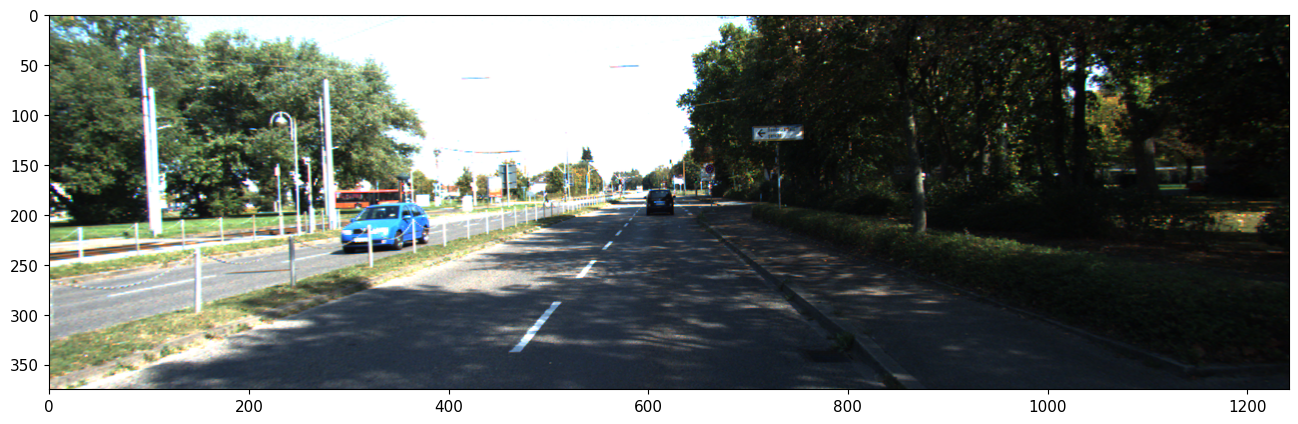

In [58]:
left_img_rgb = cv2.cvtColor(left_img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(16,9))
plt.imshow(left_img_rgb)

In [59]:
disp_bm = compute_disparity_map(
    left_img, right_img, matcher='bm', rgb=True, verbose=True)

Matcher: BM | Disparity map computation time: 0.0213 seconds


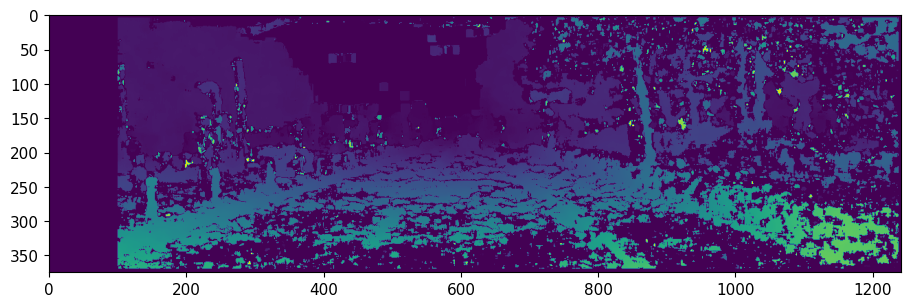

In [60]:
plt.figure(figsize=(11,7))
plt.imshow(disp_bm)

In [61]:
disp_sgbm = compute_disparity_map(
    left_img, right_img, matcher='sgbm', rgb=True, verbose=True)

Matcher: SGBM | Disparity map computation time: 0.0537 seconds


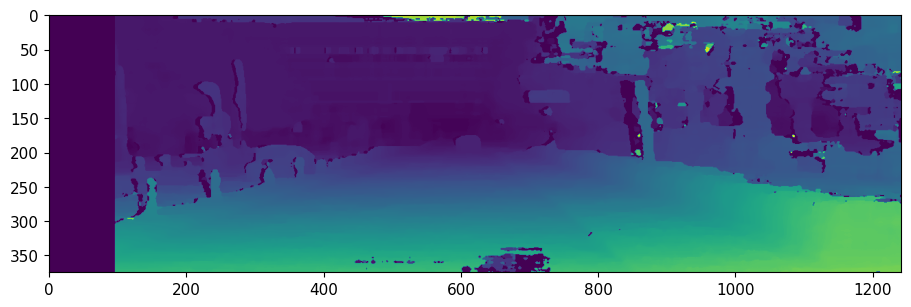

In [62]:
plt.figure(figsize=(11,7))
plt.imshow(disp_sgbm)

In [63]:
model = yolov5.load('yolov5s.pt')
model.conf = 0.25 # NMS confidence threshold 
model.iou = 0.45 # NMS IoU threshold
model.agnostic = False # NMS class agnostic
model.multi_label = False # NMS multiple labels per box 
model.max_det = 1000 # maximum number of detections per image

In [64]:
res = model(left_img_rgb, size=1280)

In [65]:
print(res)

image 1/1: 375x1242 2 cars, 1 traffic light
Speed: 2.1ms pre-process, 4.7ms inference, 0.7ms NMS per image at shape (1, 3, 416, 1280)


In [66]:
# parse results 
predictions = res.pred[0]
boxes = predictions[:, :4] # x1, y1, x2, y2
scores = predictions[:, 4]
categories = predictions[:, 5]

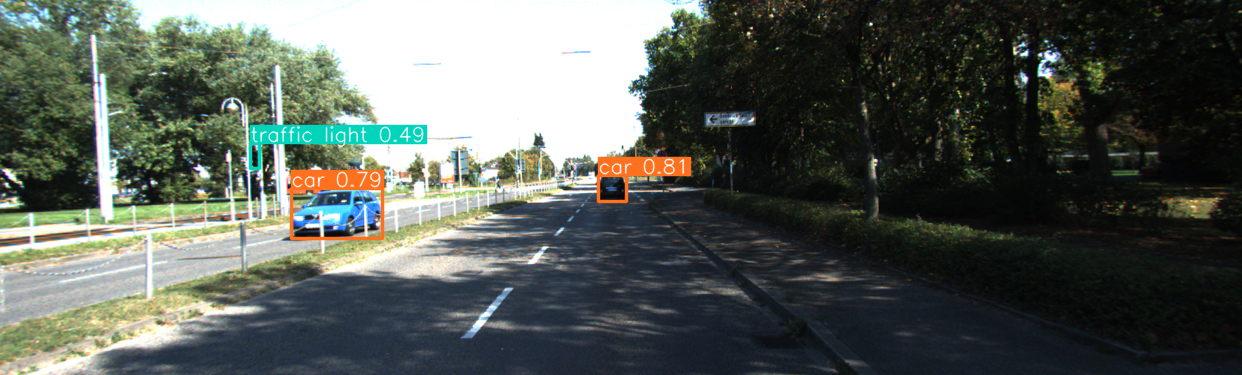

In [67]:
res.show()

In [68]:
print(boxes)

tensor([[598.05096, 175.23485, 626.84662, 201.46193],
        [291.09756, 188.60675, 382.71570, 238.52939],
        [250.49486, 143.40227, 259.03360, 168.81027]], device='cuda:0')


In [69]:
box = boxes[0].cpu().numpy()

(26, 28, 3)


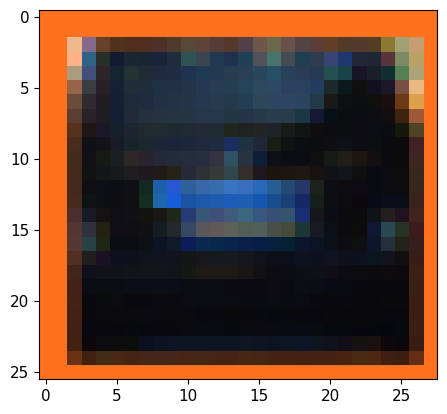

In [70]:
bbox = left_img_rgb[int(box[1]):int(box[3]), int(box[0]):int(box[2]), :]
print(bbox.shape)
plt.imshow(bbox)

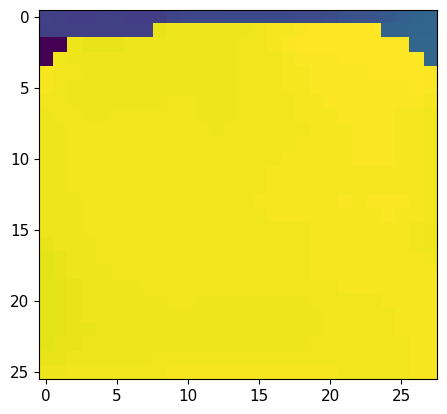

In [71]:
bbox_disp = disp_sgbm[int(box[1]):int(box[3]), int(box[0]):int(box[2])]
plt.imshow(bbox_disp)

In [79]:
max_disp = np.max(bbox_disp)
print(max_disp)

8.25


In [76]:
min_disp = np.min(bbox_disp[bbox_disp > 0])
print(min_disp)

0.6875


In [80]:
depth = baseline * focal_length / max_disp
print(depth)

47.192727272727275


In [82]:
def get_distances(preds, disparity_map, baseline: float, focal_length: float): 
    preds = preds.cpu().numpy()
    depths = []
    for box in preds: 
        disp = disparity_map[int(box[1]):int(box[3]), int(box[0]):int(box[2])]
        max_disp = np.max(disp)
        depth = baseline * focal_length / max_disp
        depths.append(depth)
    
    return depths

In [84]:
depths = get_distances(boxes, disp_sgbm, baseline, focal_length)
print(depths)

[47.192727272727275, 14.902966507177034, 32.11051546391753]


In [85]:
def show_depths(
    model, 
    left_img, 
    right_img, 
    matcher: str, 
    baseline: float, 
    focal_length: float, 
    img_size: int = 1280
):
    disp_map = compute_disparity_map(left_img, right_img, matcher=matcher, rgb=True, verbose=True)
    res = model(left_img, size=img_size)
    predictions = res.pred[0]
    boxes = predictions[:, :4] # x1, y1, x2, y2
    boxes = boxes.cpu().numpy()
    distances = get_distances(boxes, disp_map, baseline, focal_length)
    #TODO plot the bboxes and distances 
    
    return None

In [ ]:
# a function to go through every box and get the min distance in that box 
# what to do with overlapping boxes?? cutout?
def object_distances(preds, disp_map): 
    
      
    return None 

In [29]:
idx = random.randint(0, len(imgs_left) - 1)
print(f"Index: {idx}")
left_img = cv2.imread(imgs_left[idx])
right_img = cv2.imread(imgs_right[idx])
print(f"Left img: {imgs_left[idx]}")
print(f"Right img: {imgs_right[idx]}")

Index: 192
Left img: /data/kitti/stereo/training/image_2/000180_12.png
Right img: /data/kitti/stereo/training/image_3/000180_12.png


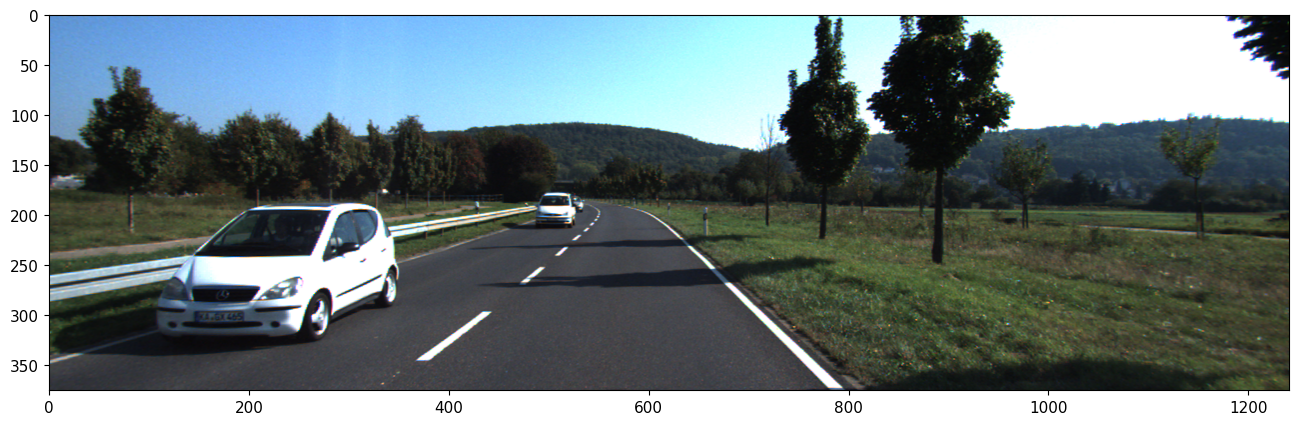

In [30]:
left_img_rgb = cv2.cvtColor(left_img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(16,9))
plt.imshow(left_img_rgb)

In [31]:
model_seg = yolov5.load('yolov5s-seg.pt')
model_seg.conf = 0.25 # NMS confidence threshold 
model_seg.iou = 0.45 # NMS IoU threshold
model_seg.agnostic = False # NMS class agnostic
model_seg.multi_label = False # NMS multiple labels per box 
model_seg.max_det = 1000 # maximum number of detections per image

In [35]:
res_seg = model_seg(left_img_rgb, size=1280)

In [38]:
print(type(res_seg))

<class 'yolov5.models.common.Detections'>


In [40]:
len(res_seg)

1

In [41]:
res.pred[0].cpu().numpy()

array([[     107.28,      190.04,      345.66,      329.13,      1.6523,          94],
       [     487.47,       177.1,      527.92,      213.78,      1.3951,          96],
       [     523.71,      181.92,       535.2,      197.58,     0.61468,          96]], dtype=float32)

In [46]:
res_seg.xywh

[tensor([[226.46982, 259.58420, 238.38385, 139.09607,   1.65230,  94.00000],
         [507.69525, 195.43915,  40.44290,  36.68703,   1.39505,  96.00000],
         [529.45599, 189.75412,  11.49426,  15.66142,   0.61468,  96.00000]], device='cuda:0')]